In [1]:
import controllers
import controlpy
import control_utils
import dynamics_models
import numpy as np
import polytope
import system_id
import tqdm
import uncertainty_utils
import experiment_utils
import trajectory_optimizers

import matplotlib
import matplotlib.pyplot as plt
# matplotlib.rcParams['text.usetex'] = True
plt.rc('font', size=16)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'large'

## SETUP

In [13]:
# Dynamics Parameters
n_states = 4
n_inputs = 2
dt = 0.1
init_state = np.array([-3.5,0, np.pi/2, 0])
linearization_state = np.zeros(n_states)
linearization_input = np.zeros(n_inputs)

# State and Input Constraints
delta_lim = np.pi / 6
a_lim = 0.3
input_limits = polytope.box2poly([[-a_lim, a_lim], [-delta_lim, delta_lim]])
state_limits = polytope.box2poly([[-4,1],[-1,1],[-5 * np.pi, 5 *np.pi],[-0.1,1]])
state_constraints = (state_limits.A, state_limits.b)
input_constraints = (input_limits.A, input_limits.b)
input_bounds = (-np.array([a_lim, delta_lim]), np.array([a_lim, delta_lim]))

# Control Task
Q = np.diag([1, 10, 1, 1]) 
R = np.eye(n_inputs)
stage_cost = lambda x, u: x.T @ Q @ x + u.T @ R @ u

num_init_episodes = 1
init_input_noise_var = 1e-3
init_input_noise = init_input_noise_var * np.eye(n_inputs)
t_inp = uncertainty_utils.calc_t(0.95, n_inputs)
idb = t_inp * np.sqrt(init_input_noise_var)
input_noise_bound = polytope.box2poly([[-idb, idb]] * n_inputs)

# Noise and Disturbances
process_noise_var = 1e-5
process_noise = process_noise_var * np.eye(n_states)
t = uncertainty_utils.calc_t(0.95, n_states)
db = t * np.sqrt(process_noise_var)
disturbance_bound = polytope.box2poly([[-db, db]] * n_states)

# Experiment Details
episode_length = int(10 / dt)
controller_horizon = 5
state_reference = np.zeros(n_states)
input_reference = np.zeros(n_inputs)
num_episodes = 10

# System ID
h = 2
lamb = 1e-2
n_sysid_pts = 500
n_sysid_it = 10

def model_callback(model, controller, episode_length):
#     As, Bs, Cs, covs, errors = model.regress_models(controller.x_traj.value.T, controller.u_traj.value.T)
    u_ss = controller.input_safe_set @ controller.multipliers.value
    input_traj = np.vstack((controller.u_traj[:,1:].value.T, u_ss))
    As, Bs, Cs, covs, errors = model.regress_models(controller.x_traj[:,1:].value.T, input_traj)
    return As, Bs, Cs, covs, errors

# Save Results
save_dir = "dubin_car_expts_v2/"
save_data = False

# Vehicle
def get_vehicle():
    init_state_noisy = np.random.multivariate_normal(init_state, process_noise)
    vehicle = dynamics_models.DubinCar(init_state_noisy, dt, process_noise, use_ode_integrator=False)
    return vehicle

def sim_traj(vehicle, controller, input_limits, episode_length=episode_length, model=None, model_callback=None, input_noise=None):
    x_traj = [vehicle.x]
    u_traj = []
    
    x_pred_trajs = []
    u_pred_trajs = []
    model_covs = []
    
    slacks = []
    terminal_slacks = []
    
    for _ in tqdm.tqdm(range(episode_length)):
        u_command = controller.solve(x_traj[-1])
        if u_command is None:
            print("controller error at iteration %d" %_)
            print("state:")
            print(x_traj[-1])
            break
        if input_noise is not None: 
            u_noise = np.random.multivariate_normal(np.zeros(input_limits[0].shape), input_noise)
            u_command = u_command + u_noise
        if model is not None:
            As, Bs, Cs, covs, errors = model_callback(model, controller, episode_length)
            controller.set_models(As, Bs, Cs)
            model_covs.append(covs)
        u = np.minimum(np.maximum(input_limits[0], u_command), input_limits[1])
        x_next = vehicle.f(u)

        x_traj.append(x_next)
        u_traj.append(u)
        
        if hasattr(controller, "x_traj"):
            x_pred_trajs.append(controller.x_traj.value.T)
            u_pred_trajs.append(controller.u_traj.value.T)

            slacks.append(controller.slack.value)
            terminal_slacks.append(controller.terminal_slack.value)
        
    return np.array(x_traj), np.array(u_traj), x_pred_trajs, u_pred_trajs, slacks, terminal_slacks, model_covs

## Plotting
l = 0.125
w = 0.075
figsize = (8,4)
state_lims_proj = state_limits.project([1,2])

def plot_experiment(traj_list, x_preds, ax, xlims=(-5,2), ylims=(-1.5, 1.5), lw=2, k=10,bbox=(0,0)):
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_xlabel("x in (m)")
    ax.set_ylabel("y in (m)")
    state_lims_proj.plot(ax=ax, alpha=1, color="w", edgecolor="b", linewidth=lw)
    
    for x_traj in traj_list:
        ss = ax.plot(x_traj[0,:], x_traj[1,:], "r--", label="safe set")
        
    for pred in x_preds:
        ps = ax.plot(pred[:,0], pred[:,1], color="tab:blue", linestyle="--", alpha=0.6, label="predictions")
        
    x_traj = traj_list[-1].T
    ts = ax.plot(x_traj[:,0], x_traj[:,1], "k", lw=lw, label="final trajectory")
    patches = [dynamics_models.plot_vehicle(x[:3], l, w, alpha=0.4) for x in np.rollaxis(x_traj[::k,:],0)]
    for patch in patches:
        ax.add_patch(patch)
    handles, labels = ax.get_legend_handles_labels()
    handles, labels = zip(*[(handles[i], labels[i]) for i in [0,-1,-2]])
    handles = list(handles)
    labels = list(labels)
    handles.append(ax.patches[0])
    labels.append("state constraints")
    ax.legend(handles, labels, bbox_to_anchor=bbox)

## Initial Trajectories With Tracking MPC

In [14]:
vehicle = get_vehicle()
A, B, C = vehicle.get_linearization(linearization_state, linearization_input, dt)
A[1,2] = 0.025
K = controlpy.synthesis.controller_lqr_discrete_time(A, B, Q, R)

init_state_limits = control_utils.pontryagin_difference(state_limits, disturbance_bound)
init_input_limits = control_utils.pontryagin_difference(input_limits, input_noise_bound)
init_state_constraints = (init_state_limits.A, init_state_limits.b)
init_input_constraints = (init_input_limits.A, init_input_limits.b)

controller = controllers.LTI_MPC_Tracker(A, B, C,
                                         controller_horizon * 2, 
                                         Q, 3*R, state_reference, input_reference,
                                         init_state_constraints, init_input_constraints)
controller.build()

In [15]:
x_init_trajs = []
u_init_trajs = []
for _ in range(num_init_episodes):
    vehicle = get_vehicle()
    x_init_traj, u_init_traj, x_init_preds, u_init_preds, slacks, terminal_slacks, model_covs = sim_traj(vehicle, controller, input_bounds, input_noise=init_input_noise)
    x_init_trajs.append(x_init_traj)
    u_init_trajs.append(u_init_traj)
init_value_functions = [control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, stage_cost) for x_traj, u_traj in zip(x_init_trajs, u_init_trajs)]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.55it/s]


[748.2661742563888]


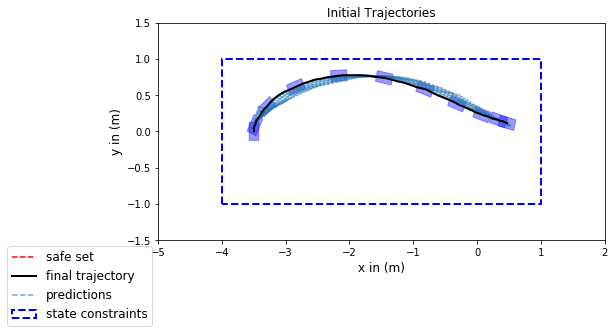

In [16]:
plt.figure(figsize=figsize)
ax = plt.gca()
init_trajs = [x.T for x in x_init_trajs]
plot_experiment(init_trajs, x_init_preds, ax)
plt.title("Initial Trajectories")
print([q[0] for q in init_value_functions])

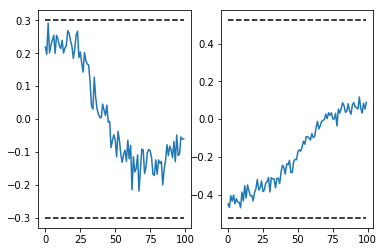

In [17]:
fig, ax = plt.subplots(1,2)
for u_traj in u_init_trajs:
    ax[0].plot(u_traj[:,0])
    ax[1].plot(u_traj[:,1])
for i, lim in enumerate((a_lim, delta_lim)):
    ax[i].plot([lim] * episode_length, "k--")
    ax[i].plot([-lim] * episode_length, "k--")

In [18]:
u_init_trajs[0].shape

(100, 2)

In [19]:
filename = "tracking_mpc"
if save_data:
    experiment_utils.save_result(save_dir, filename, x_init_trajs, u_init_trajs, None, None, None)

## Learning MPC With Local Linear Regression

In [20]:
controller = controllers.LTV_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q,R, state_reference, input_reference,
                                     state_constraints, input_constraints)

for x_init_traj, u_init_traj, init_value_func in zip(x_init_trajs, u_init_trajs, init_value_functions):
    controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, init_value_func)

In [21]:
model = system_id.LocalLinearModel(n_states, n_inputs, h, lamb, n_sysid_pts=n_sysid_pts, n_sysid_it=n_sysid_it)
for x_init_traj, u_init_traj in zip(x_init_trajs, u_init_trajs):
    model.add_trajectory(x_init_traj, u_init_traj)

In [22]:
slack_per_episode = []
term_slack_per_episode = []
model_covs_per_episode = []
x_preds_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks, model_covs = sim_traj(vehicle, controller, input_bounds, 
                                                                                     model=model, model_callback=model_callback)
    
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, stage_cost)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    model.add_trajectory(x_traj, u_traj)
    
    As, Bs, Cs, covs, errors = model.regress_models(x_traj[:controller.N,:], u_traj[:controller.N,:])
    controller.set_models(As, Bs, Cs)
    
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)
    model_covs_per_episode.append(model_covs)
    x_preds_per_episode.append(x_preds)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.22it/s]


Text(0.5,1,'Naive LTV LMPC')

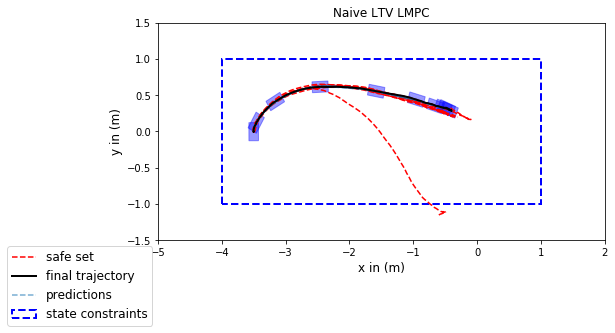

In [23]:
plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list[num_init_episodes:], x_preds, ax)
ax.set_title("Naive LTV LMPC")

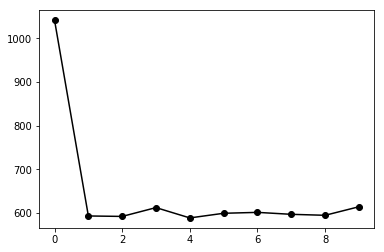

In [24]:
traj_costs = [q[0] for q in controller.value_func_list[num_init_episodes:]]
plt.plot(traj_costs, "k-o")

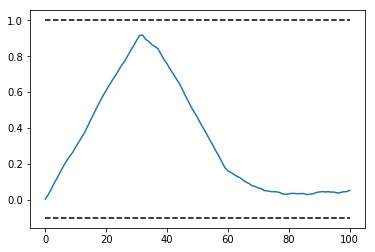

In [25]:
state_vtcs= polytope.extreme(state_limits)
v_max = np.max(state_vtcs[:,-1])
v_min = np.min(state_vtcs[:,-1])
plt.plot(x_traj[:,3])
plt.plot(np.arange(x_traj.shape[0]), np.ones(x_traj.shape[0]) * v_max, "k--")
plt.plot(np.arange(x_traj.shape[0]), np.ones(x_traj.shape[0]) * v_min, "k--")

In [118]:
filename = "naive_ltv_lmpc"
if save_data:
    experiment_utils.save_result(save_dir, filename, controller.traj_list, controller.input_traj_list, x_preds_per_episode, controller.value_func_list, model_covs_per_episode)

## Learning-Based Learning MPC

In [27]:
controller = controllers.LBLMPC(A, B, C,
                                    controller_horizon, 
                                    Q, R, state_reference, input_reference,
                                    state_constraints, input_constraints, (disturbance_bound.A, disturbance_bound.b))
## Minimal Invariant Cannot Be Computed
alpha = 2
M = polytope.box2poly([[-db * alpha, db * alpha]] * n_states)
X = polytope.Polytope(*controller.state_constraints)
U = polytope.Polytope(*controller.input_constraints)
X_bar = control_utils.pontryagin_difference(X, M)
U_bar = control_utils.pontryagin_difference(U, control_utils.poly_transform(M, controller.K))
controller.state_constraints = (X_bar.A, X_bar.b)
controller.input_constraints = (U_bar.A, U_bar.b)
controller.init_constraint = (M.A, M.b)

for x_init_traj, u_init_traj, value_function in zip(x_init_trajs, u_init_trajs, init_value_functions):
    x_nominal, u_nominal = control_utils.compute_nominal_traj(x_init_traj.T, u_init_traj.T, A, B, C, controller.K)
    controller.add_trajectory(x_nominal[:,:-1], u_nominal, value_function)

In [28]:
model = system_id.LocalLinearModel(n_states, n_inputs, h, lamb, n_sysid_pts=n_sysid_pts, n_sysid_it=n_sysid_it)
for x_init_traj, u_init_traj in zip(x_init_trajs, u_init_trajs):
    model.add_trajectory(x_init_traj, u_init_traj)

In [29]:
slack_per_episode = []
term_slack_per_episode = []
model_covs_per_episode = []
x_preds_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks, model_covs = sim_traj(vehicle, controller, input_bounds, 
                                                                                     model=model, model_callback=model_callback)
    
    x_nominal, u_nominal = control_utils.compute_nominal_traj(x_traj.T, u_traj.T, A, B, C, controller.K)
    value_function = control_utils.compute_traj_cost(x_nominal[:,:-1], u_nominal, stage_cost)

    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    model.add_trajectory(x_traj, u_traj)
    
    As, Bs, Cs, covs, errors = model.regress_models(x_traj[:controller.N,:], u_traj[:controller.N,:])
    controller.set_models(As, Bs, Cs)
    
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)
    model_covs_per_episode.append(model_covs)
    x_preds_per_episode.append(x_preds)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.86it/s]


Text(0.5,1,'LBLMPC')

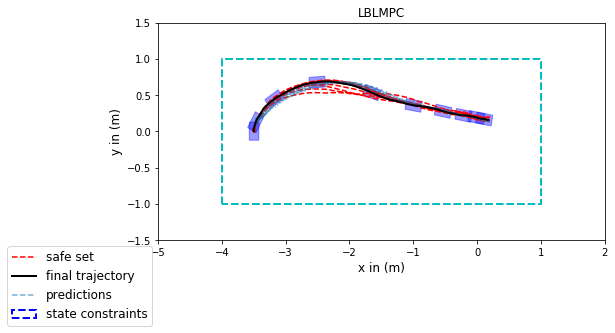

In [30]:
plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list[num_init_episodes:], x_preds, ax)
constraint_tight = X_bar.project([1,2])
constraint_tight.plot(ax=ax, alpha=1, color="w", edgecolor="c", linewidth=2)
ax.set_title("LBLMPC")

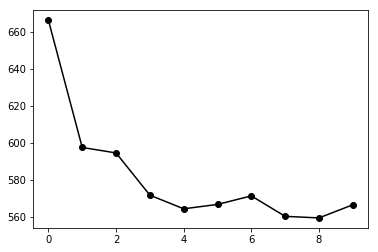

In [31]:
traj_costs = [q[0] for q in controller.value_func_list[num_init_episodes:]]
plt.plot(traj_costs, "k-o")

In [124]:
filename = "lblmpc"
if save_data:
    experiment_utils.save_result(save_dir, filename, controller.traj_list, controller.input_traj_list, x_preds_per_episode, controller.value_func_list, model_covs_per_episode)

### LTV LMPC with Local Safe Sets

In [33]:
safe_set_size = 30
n_safe_set_it = 3
controller = controllers.Local_LTV_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, input_reference,
                                     state_constraints, input_constraints, n_safe_set_it, safe_set_size)
controller.build()
for x_init_traj, u_init_traj, value_function in zip(x_init_trajs, u_init_trajs, init_value_functions):
    controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, value_function)

In [34]:
model = system_id.LocalLinearModel(n_states, n_inputs, h, lamb, n_sysid_pts=n_sysid_pts, n_sysid_it=n_sysid_it)
for x_init_traj, u_init_traj in zip(x_init_trajs, u_init_trajs):
    model.add_trajectory(x_init_traj, u_init_traj)

In [35]:
slack_per_episode = []
term_slack_per_episode = []
model_covs_per_episode = []
x_preds_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks, model_covs = sim_traj(vehicle, controller, input_bounds, 
                                                                                     model=model, model_callback=model_callback)
    
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, stage_cost)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    model.add_trajectory(x_traj, u_traj)
    
    As, Bs, Cs, covs, errors = model.regress_models(x_traj[:controller.N,:], u_traj[:controller.N,:])
    controller.set_models(As, Bs, Cs)
    
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)
    model_covs_per_episode.append(model_covs)
    x_preds_per_episode.append(x_preds)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.08it/s]


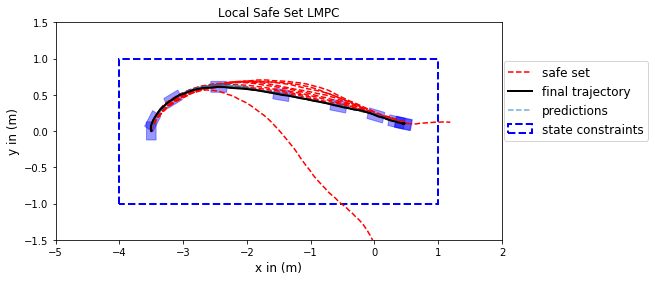

In [36]:
plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list[num_init_episodes:], x_preds, ax, bbox= (0.99,0.85))
ax.set_title("Local Safe Set LMPC")
plt.savefig("local_ltv_lmpc_trajs.png", bbox_inches="tight")

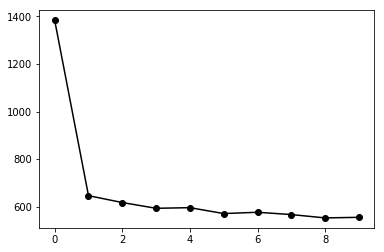

In [37]:
traj_costs = [q[0] for q in controller.value_func_list[num_init_episodes:]]
plt.plot(traj_costs, "k-o")

In [38]:
filename = "local_ltv_lmpc"
if save_data:
    experiment_utils.save_result(save_dir, filename, controller.traj_list, controller.input_traj_list, x_preds_per_episode, controller.value_func_list, model_covs_per_episode)

## True LTV LMPC with Loc Lin Reg

In [39]:
controller = controllers.True_LTV_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, input_reference,
                                     state_constraints, input_constraints)
for x_init_traj, u_init_traj, value_function in zip(x_init_trajs, u_init_trajs, init_value_functions):
    controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, value_function)

In [40]:
model = system_id.LocalLinearModel(n_states, n_inputs, h, lamb,  n_sysid_pts=n_sysid_pts, n_sysid_it=n_sysid_it)
for x_init_traj, u_init_traj in zip(x_init_trajs, u_init_trajs):
    model.add_trajectory(x_init_traj, u_init_traj)
    
def ltv_model_callback(vehicle, controller, episode_length):
    i = controller.i
    N = controller.N
    i = min(episode_length - N, i)
    x_traj = controller.traj_list[-1][:,i:i+N]
    u_traj = controller.input_traj_list[-1][:,i:i+N]
    As, Bs, Cs, covs, errors = model.regress_models(controller.x_traj.value.T, controller.u_traj.value.T)
    return As, Bs, Cs, covs, errors

In [41]:
slack_per_episode = []
term_slack_per_episode = []
model_covs_per_episode = []
x_preds_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks, model_covs = sim_traj(vehicle, controller, input_bounds, 
                                                                                     model=model, model_callback=ltv_model_callback)
    
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, stage_cost)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    model.add_trajectory(x_traj, u_traj)
    
    As, Bs, Cs, covs, errors = model.regress_models(x_traj[:controller.N,:], u_traj[:controller.N,:])
    controller.set_models(As, Bs, Cs)
    
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)
    model_covs_per_episode.append(model_covs)
    x_preds_per_episode.append(x_preds)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.50it/s]


Text(0.5,1,'True TV LMPC')

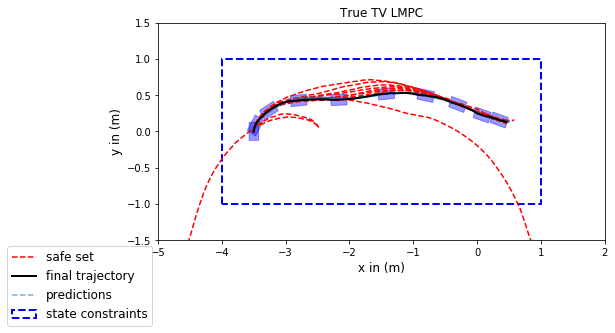

In [42]:
plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list[num_init_episodes:], x_preds, ax)
ax.set_title("True TV LMPC")

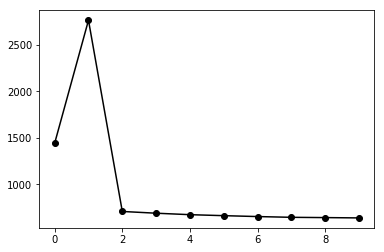

In [43]:
traj_costs = [q[0] for q in controller.value_func_list[num_init_episodes:]]
plt.plot(traj_costs, "k-o" )

In [44]:
filename = "true_ltv_lmpc"
if save_data:
    experiment_utils.save_result(save_dir, filename, controller.traj_list, controller.input_traj_list, x_preds_per_episode, controller.value_func_list, model_covs_per_episode)

## LTI LMPC

In [46]:
controller = controllers.LTI_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, input_reference, 
                                     state_constraints, input_constraints)
for x_init_traj, u_init_traj, value_function in zip(x_init_trajs, u_init_trajs, init_value_functions):
    controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, value_function)

In [47]:
slack_per_episode = []
term_slack_per_episode = []
x_preds_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks, model_covs = sim_traj(vehicle, controller, input_bounds)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, stage_cost)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)
    x_preds_per_episode.append(x_preds)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.32it/s]


Text(0.5,1,'LTI LMPC')

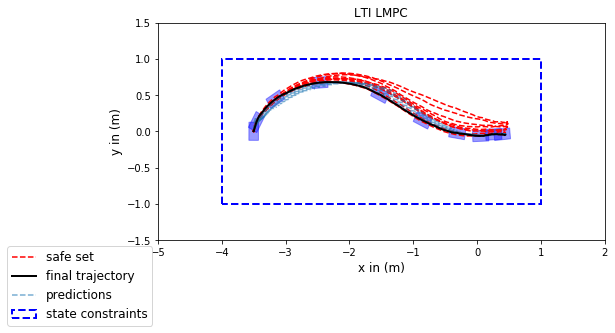

In [48]:
plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list[num_init_episodes:], x_preds, ax)
ax.set_title("LTI LMPC")

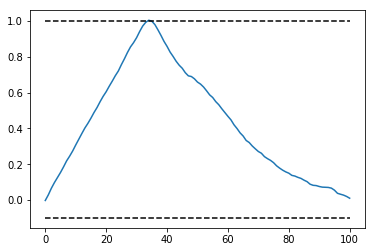

In [49]:
state_vtcs= polytope.extreme(state_limits)
v_max = np.max(state_vtcs[:,-1])
v_min = np.min(state_vtcs[:,-1])
plt.plot(x_traj[:,3])
plt.plot(np.arange(x_traj.shape[0]), np.ones(x_traj.shape[0]) * v_max, "k--")
plt.plot(np.arange(x_traj.shape[0]), np.ones(x_traj.shape[0]) * v_min, "k--")

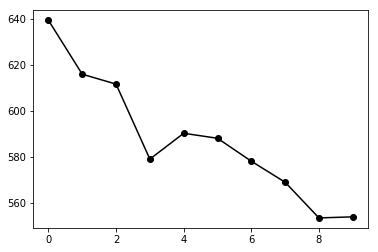

In [50]:
traj_costs = [q[0] for q in controller.value_func_list[num_init_episodes:]]
plt.plot(traj_costs, "k-o" )

In [51]:
filename = "lti_lmpc"
if save_data:
    experiment_utils.save_result(save_dir, filename, controller.traj_list, controller.input_traj_list, x_preds_per_episode, controller.value_func_list, None)

## LTV Tube LMPC

In [52]:
## Minimal Invariant Cannot Be Computed
alpha = 4
M = polytope.box2poly([[-db * alpha, db * alpha]] * n_states)
minimal_invariant = (M.A, M.b)

controller = controllers.LTV_Tube_LMPC(A, B, C,
                                    controller_horizon, 
                                    Q, R, state_reference, input_reference,
                                    state_constraints, input_constraints, minimal_invariant)

for x_init_traj, u_init_traj, value_function in zip(x_init_trajs, u_init_trajs, init_value_functions):
    controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, value_function)

In [53]:
model = system_id.LocalLinearModel(n_states, n_inputs, h, lamb, n_sysid_pts=n_sysid_pts, n_sysid_it=n_sysid_it)
for x_init_traj, u_init_traj in zip(x_init_trajs, u_init_trajs):
    model.add_trajectory(x_init_traj, u_init_traj)

In [54]:
slack_per_episode = []
term_slack_per_episode = []
model_covs_per_episode = []
x_preds_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks, model_covs = sim_traj(vehicle, controller, input_bounds, 
                                                                                     model=model, model_callback=model_callback)
    
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, stage_cost)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    model.add_trajectory(x_traj, u_traj)
    
    As, Bs, Cs, covs, errors = model.regress_models(x_traj[:controller.N,:], u_traj[:controller.N,:])
    controller.set_models(As, Bs, Cs)
    
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)
    model_covs_per_episode.append(model_covs)
    x_preds_per_episode.append(x_preds)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.97it/s]


Text(0.5,1,'LTV Tube LMPC')

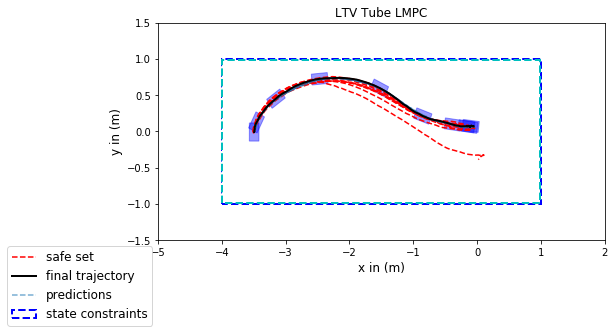

In [55]:
plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list[num_init_episodes:], x_preds, ax)
X_bar = polytope.Polytope(*controller.state_constraints)
constraint_tight = X_bar.project([1,2])
constraint_tight.plot(ax=ax, alpha=1, color="w", edgecolor="c", linewidth=2)
ax.set_title("LTV Tube LMPC")

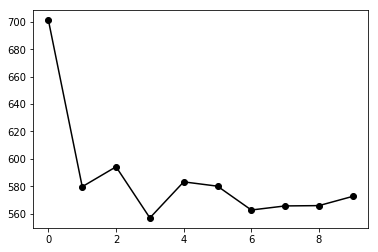

In [56]:
traj_costs = [q[0] for q in controller.value_func_list[num_init_episodes:]]
plt.plot(traj_costs, "k-o" )
# plt.ylim((500,800))

In [57]:
filename = "tube_ltv_lmpc"
if save_data:
    experiment_utils.save_result(save_dir, filename, controller.traj_list, controller.input_traj_list, x_preds_per_episode, controller.value_func_list, model_covs_per_episode)

## Trajectory Optimization Using SCP, ground truth

In [58]:
traj_opt = trajectory_optimizers.SCP_Traj_Opt(episode_length, Q, R, state_reference, np.zeros(n_inputs), state_constraints, input_constraints, tolerance=1e-5, regularization=1e0)
traj_opt.build()

In [59]:
for i in range(20):
    vehicle = dynamics_models.DubinCar(init_state, dt, process_noise*0, use_ode_integrator=False)
    if i == 0:
        As, Bs, Cs = control_utils.linearize_around(vehicle, x_init_traj.T, u_init_traj.T, vehicle.dt)
        x_traj_opt, u_traj_opt, converged = traj_opt.solve_iteration(x_init_traj.T, u_init_traj.T, As, Bs)
    else:
        As, Bs, Cs = control_utils.linearize_around(vehicle, x_traj.T, u_traj.T, vehicle.dt)
        x_traj_opt, u_traj_opt, converged = traj_opt.solve_iteration(x_traj.T, u_traj.T, As, Bs)
    
    controller = traj_opt.get_controller()
    x_traj, u_traj, _, _, _, _ = experiment_utils.sim_traj(vehicle, controller, input_bounds, episode_length)
    if converged:
        break
print("converged in %d iterations" % traj_opt.i)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 5884.10it/s]


converged in 16 iterations


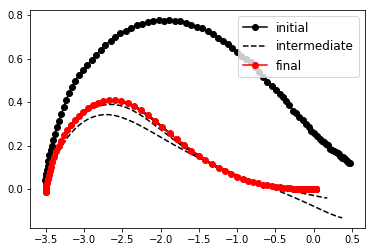

In [60]:
plt.plot(traj_opt.traj_list[0][0,:], traj_opt.traj_list[0][1,:], "k-o", label="initial")
for traj in traj_opt.traj_list[1:-1]:
    plt.plot(traj[0,:], traj[1,:], "k--", label="intermediate")
plt.plot(traj_opt.traj_list[-1][0,:], traj_opt.traj_list[-1][1,:], "r-o", label="final")
ax = plt.gca()
handles, labels= ax.get_legend_handles_labels()
plt.legend([handles[0], handles[1], handles[-1]], [labels[0], labels[1], labels[-1]])

504.90559487626354


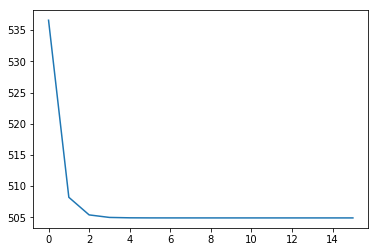

In [61]:
plt.plot(traj_opt.solution_costs)
print(traj_opt.solution_costs[-1])


In [62]:
true_optimal_cost = []
for i in range(100):
    controller = traj_opt.get_controller()
    vehicle = dynamics_models.DubinCar(init_state, dt, process_noise, use_ode_integrator=False)
    x_traj, u_traj, _, _, _, _, _ = sim_traj(vehicle, controller, input_bounds)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, stage_cost)
    true_optimal_cost.append(value_function[0])
print(np.mean(true_optimal_cost))

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 5558.98it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 4550.12it/s]


507.8616241958843


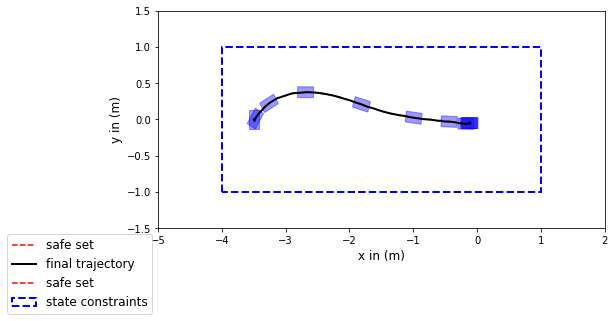

In [63]:
plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment([x_traj.T], [], ax)
# ax.set_title("LTV Tube LMPC")

In [65]:
controller = controllers.LTI_MPC_Tracker(A, B, C,
                                         episode_length, 
                                         Q, R, state_reference, input_reference,
                                         state_constraints, input_constraints)
controller.build()
_ = controller.solve(init_state)
x_true_opt = controller.x_traj.value
u_true_opt = controller.u_traj.value
true_cost = controller.cost
controller = controllers.Open_Loop_Controller()
controller.build(u_true_opt)


In [66]:
vehicle = dynamics_models.DubinCar(init_state, dt, process_noise, use_ode_integrator=False)
x_traj, u_traj, _, _, _, _, _ = sim_traj(vehicle, controller, input_bounds)
value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, stage_cost)
print(value_function[0])

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 5555.81it/s]


606.6139960813903


## Trajectory Optimization using SCP, from Data

In [67]:
model = system_id.LocalLinearModel(n_states, n_inputs, h, lamb, n_sysid_pts=n_sysid_pts, n_sysid_it=n_sysid_it)
for x_init_traj, u_init_traj in zip(x_init_trajs, u_init_trajs):
    model.add_trajectory(x_init_traj, u_init_traj)

def estimate_traj(model, controller, init_state, episode_length):
    x_sim = [init_state]
    u_sim = []
    for i in range(episode_length):
        u = controller.solve(x_sim[-1])
        x, cov = model.predict(x_sim[-1].reshape((1, n_states)), u.reshape((1, n_inputs)))
        x = x[0]
        u_sim.append(u)
        x_sim.append(x)
    return np.array(x_sim), np.array(u_sim)
    

In [68]:
def optimize_trajectory(traj_opt, model, x_init_traj, u_init_traj):
    for i in tqdm.tqdm(range(20)):
        vehicle = get_vehicle()
        if i == 0:
            As, Bs, Cs, covs, error = model.regress_models(x_init_traj, u_init_traj)
            x_traj_opt, u_traj_opt, converged = traj_opt.solve_iteration(x_init_traj.T, u_init_traj.T, As, Bs)
        else:
            As, Bs, Cs, covs, error = model.regress_models(x_traj, u_traj)
            x_traj_opt, u_traj_opt, converged = traj_opt.solve_iteration(x_traj.T, u_traj.T, As, Bs)

        controller = traj_opt.get_controller()
        x_traj, u_traj = estimate_traj(model, controller, x_init_traj[0,:], episode_length)
        if converged:
            break
    

In [69]:
x_trajs_per_episode = [x_init_traj]
u_trajs_per_episode = [u_init_traj]
value_functions_per_episode = [init_value_functions[-1]]
for episode in range(num_episodes):
    traj_opt = trajectory_optimizers.SCP_Traj_Opt(episode_length, Q, R, state_reference, np.zeros(n_inputs), state_constraints, input_constraints, tolerance=1e-5, regularization=1e-9)
    traj_opt.build()
    
    optimize_trajectory(traj_opt, model, x_trajs_per_episode[-1], u_trajs_per_episode[-1])
    vehicle = get_vehicle()#dynamics_models.DubinCar(init_state, dt, process_noise * 0, use_ode_integrator=False)
    controller = traj_opt.get_controller()
    x_traj, u_traj, _, _, _, _, _ = sim_traj(vehicle, controller, input_bounds)
    
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, stage_cost)
    value_functions_per_episode.append(value_function)
    model.add_trajectory(x_traj, u_traj)
    
    x_trajs_per_episode.append(x_traj)
    u_trajs_per_episode.append(u_traj)

 30%|████████████████████████▉                                                          | 6/20 [00:08<00:18,  1.35s/it]

 35%|█████████████████████████████                                                      | 7/20 [00:09<00:17,  1.34s/it]

 25%|████████████████████▊                                                              | 5/20 [00:06<00:20,  1.36s/it]

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 5568.42it/s]

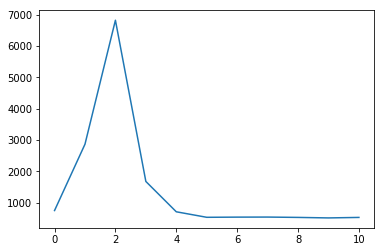

In [70]:
costs = [q[0] for q in value_functions_per_episode]
plt.plot(costs)
# plt.plot(np.mean(true_optimal_cost)* np.ones(len(costs)))
# plt.ylim((500,600)

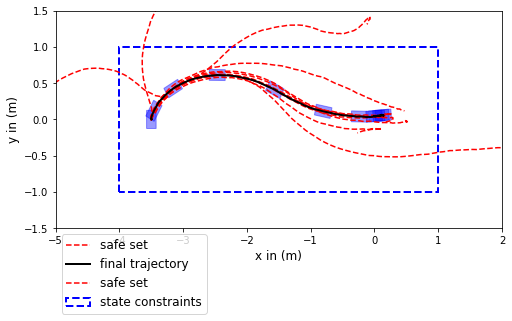

In [71]:
plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment([x.T for x in x_trajs_per_episode], [], ax)
# ax.set_title("LTV Tube LMPC")

In [ ]:
filename = "o"
if save_data:
    experiment_utils.save_result(save_dir, filename, [x.t for x in x_trajs_per_episode], [u.t for u in u_trajs_per_episode], None, value_functions_per_episode, None)

In [6]:
save_data

False